In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
def calc_ei(pxy):
    # normalizing p(x, y)
    p = pxy / pxy.sum()
    
    # dimension of x and y
    m, n = p.shape
    
    # marginal distributions
    px = p.sum(axis=1)
    py = p.sum(axis=0)
    
    # do(x) to uniform distribution, tpm = p(y|x)
    tpm = (p.T / px).T
    pu = tpm / tpm.sum()
    
    # marginal distribution of y given x ~ Unifrom Dist
    puy = pu.sum(axis=0)
    
    # replace 0 to a small positive number to avoid log error
    eps = 1E-10
    tpm_e = np.where(tpm==0, eps, tpm)
    puy_e = np.where(tpm==0, eps, puy)
    
    # calculate EI of specific x
    ei_x = (np.log2(tpm_e / puy_e) * tpm).sum(axis=1)
    
    # calculate determinism and degeneracy coefficients of specific x
    det_x = (np.log2(tpm_e * m) * tpm).sum(axis=1) / np.log2(m)
    deg_x = (np.log2(puy_e * m) * tpm).sum(axis=1) / np.log2(m)
    
    # calculate total EI
    ei_all = ei_x.mean()
    
    # calculate determinism and degeneracy coefficients, and efficiency
    det = det_x.mean()
    deg = deg_x.mean()
    eff = det - deg
    
    return tpm, eff, det, deg, ei_all, ei_x, det_x, deg_x

In [3]:
# plot
def set_plot_info(xlabel,ylabel,fontsize=14):
    plt.xlabel(xlabel,fontsize=fontsize)
    plt.ylabel(ylabel,fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

In [4]:

'loading trade network data'

country_id_group = []
with open('../../flow_network_jake/for causal visualization/country_id_group.txt', 'r') as file:
    data = file.readlines()
    for i in data:
        arr = i.split(' ')
        if len(arr) > 3:
            arr[0] = arr[0]+'_'+arr[1]
            del arr[1]
            if len(arr)!=3:
                arr[0] = arr[0]+'_'+arr[1]
                del arr[1]
                if len(arr)!=3:
                    arr[0] = arr[0]+'_'+arr[1]
                    del arr[1]
                
        arr = [arr[j].strip() for j in range(len(arr))]
        country_id_group.append(arr)
country_id_group = np.array(country_id_group)
country_id_group.shape

(190, 3)

In [5]:
country_id_group

array([['Afghanistan', '1', '49'],
       ['Afr.Other_NS', '2', '49'],
       ['Albania', '3', '89'],
       ['Algeria', '4', '104'],
       ['Angola', '5', '98'],
       ['Areas_NES', '6', '109'],
       ['Argentina', '7', '95'],
       ['Armenia', '8', '91'],
       ['Asia_NES', '9', '99'],
       ['Asia_West_NS', '10', '91'],
       ['Australia', '11', '90'],
       ['Austria', '12', '109'],
       ['Azerbaijan', '13', '46'],
       ['Bahamas', '14', '73'],
       ['Bahrain', '15', '55'],
       ['Bangladesh', '16', '41'],
       ['Barbados', '17', '97'],
       ['Belarus', '18', '46'],
       ['Belgium-Lux', '19', '105'],
       ['Belize', '20', '7'],
       ['Benin', '21', '41'],
       ['Bermuda', '22', '76'],
       ['Bolivia', '23', '71'],
       ['Bosnia_Herzg', '24', '48'],
       ['Br.Antr.Terr', '25', '1'],
       ['Brazil', '26', '90'],
       ['Bulgaria', '27', '46'],
       ['Burkina_Faso', '28', '104'],
       ['Burundi', '29', '82'],
       ['CACM_NES', '30', '75'],
  

In [6]:
'loading trade network data'
egdes_networks = []
with open('../../flow_network_jake/for causal visualization/original_network.txt', 'r') as file:
    original_network = file.readlines()
    for line in original_network:
        arr = []
        for idx,ele in enumerate(line.split(' ')):
            if idx == 2:
                arr.append(float(ele.split('\n')[0]))
            else:
                arr.append(int(ele))
        egdes_networks.append(arr)

egdes_networks = np.array(egdes_networks)
print(egdes_networks.shape)


(11968, 3)


In [7]:

'Transform the edge matrix to the adjacency matrix'
n = int(max(max(edge[:2]) for edge in egdes_networks) + 1)  # number of nodes
print(n)
# create flow matrix according to the adj
flow_matrix = np.zeros((n, n))
for edge in egdes_networks:
    node1, node2, weight = edge
    node1 =  int(node1)
    node2 =  int(node2)
    flow_matrix[node1, node2] = weight

print(flow_matrix.shape)
flow_matrix = flow_matrix[1:,1:]

original_flow = flow_matrix

191
(191, 191)


(190, 190)
190 122
\Gamma 38.51641545109923
\gamma 0.202717976058417
EI 1.9821602521656874


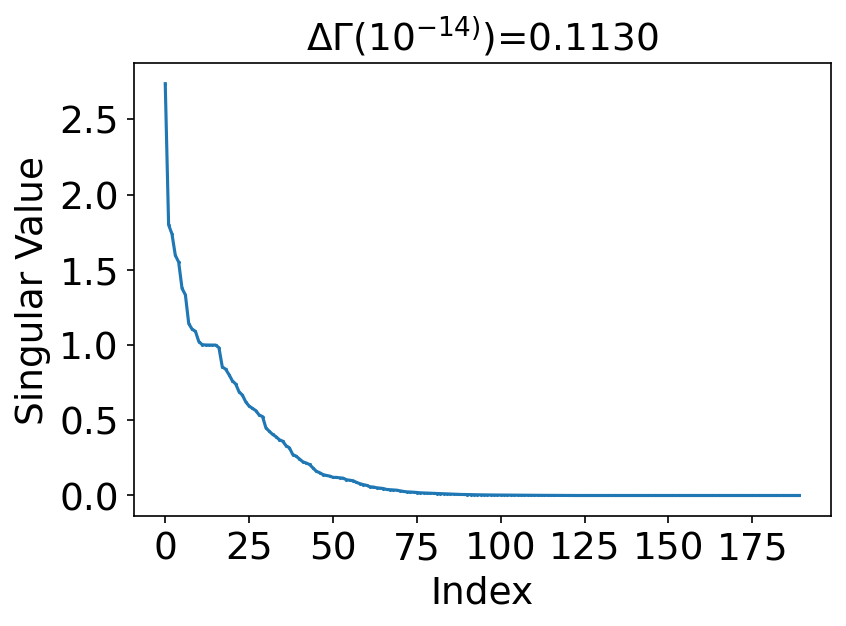

In [10]:


# Normalize 'flow' to create 'markov'
original_markov = np.zeros_like(original_flow)

for i in range(len(original_markov)):
    normalize = np.sum(original_flow[i, :])
    if normalize > 0:
        original_markov[i, :] = original_flow[i, :] / normalize
    else:
        original_markov[i, i] = 1

# Perform SVD
print(original_markov.shape)
U, original_S, V = np.linalg.svd(original_markov, full_matrices=False)


# Plot the singular values
plt.figure(dpi=150)
plt.plot(range(len(original_S)),original_S,marker='.',markersize=1)

r = original_S[original_S>(1e-14)].shape[0]
n = len(original_S)
print(n,r)

d_gamma = np.sum(original_S[:r])/r - np.sum(original_S)/n
set_plot_info('Index','Singular Value',fontsize=18)
plt.title(r'$\Delta \Gamma(10^{-14)})$='+f'{d_gamma:.4f}',fontsize=18)

print(r'\Gamma',np.sum(original_S))
print(r'\gamma',np.sum(original_S)/len(original_S))
print('EI',calc_ei(original_markov)[4])

## coarse-grain

\Gamma 38.51641545109923
\gamma 0.202717976058417
EI 1.9821602521656874
122
(190, 122)


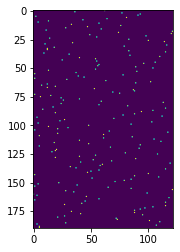

(122, 122)
\Gamma 27.584600730762364
\gamma 0.22610328467838003
EI 1.7212054632330183
64


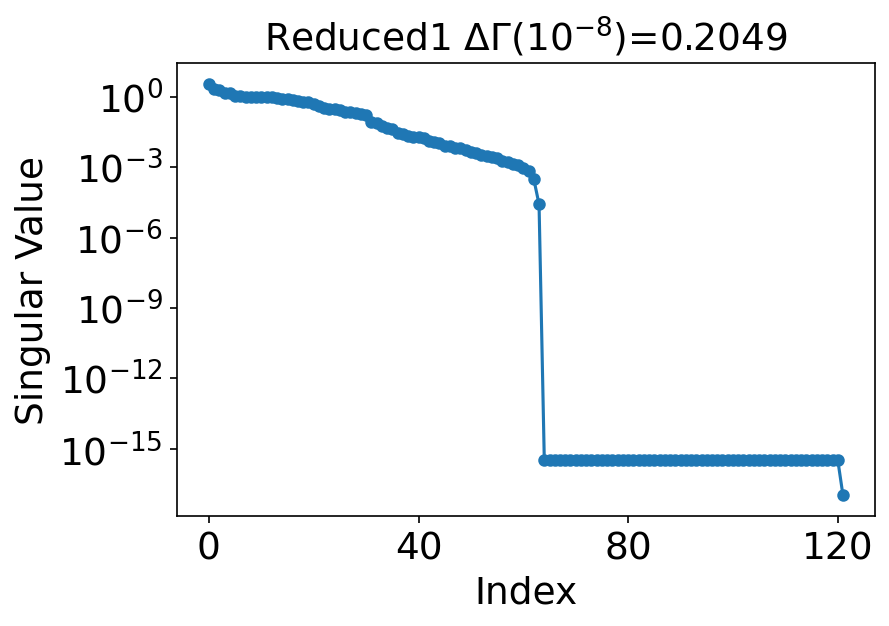

In [31]:
'k-means'
from sklearn.cluster import KMeans

# Perform SVD
U, original_S, V = np.linalg.svd(original_markov, full_matrices=False)
print(r'\Gamma',np.sum(original_S))
print(r'\gamma',np.sum(original_S)/len(original_S))
print('EI',calc_ei(original_markov)[4])
vec = V.T

epsilon = 1e-14
r = original_S[original_S>epsilon].shape[0]
n=original_markov.shape[0]
pca_pxy = original_markov @ vec[:,:r]
kmeans = KMeans(n_clusters=r,random_state=1)

print(r)
kmeans.fit(pca_pxy)
labels = [(i,kmeans.labels_[i]) for i in range(len(kmeans.labels_))]
cluster_centers = kmeans.cluster_centers_
phi = np.zeros([n,r])
for i in range(len(labels)):
    phi[labels[i][0],labels[i][1]] = 1
print(phi.shape)
plt.imshow(phi)
plt.show()
        

reduced_flow = phi.T @ original_flow @ phi

# Normalize the reduced flow matrix to create a reduced Markov matrix
reduced_markov = reduced_flow.copy()
for i in range(reduced_flow.shape[0]):
    normalize = np.sum(reduced_flow[i, :])
    if normalize > 0:
        reduced_markov[i, :] = reduced_flow[i, :] / normalize
    else:
        reduced_markov[i, i] = 1

        
# Perform SVD
print(reduced_markov.shape)
U, reduced_S, V = np.linalg.svd(reduced_markov, full_matrices=False)

# Plot the singular values
plt.figure(dpi=150)
plt.plot(range(len(reduced_S)),reduced_S,marker='.',markersize=10)
print(r'\Gamma',np.sum(reduced_S))
print(r'\gamma',np.sum(reduced_S)/len(reduced_S))
print('EI',calc_ei(reduced_markov)[4])

r = reduced_S[reduced_S>(1e-8)].shape[0]
print(r)
n = len(reduced_S)
d_gamma = np.sum(reduced_S[:r])/r - np.sum(reduced_S)/n


set_plot_info('Index','Singular Value',fontsize=18)
plt.title('Reduced1 ' + r'$\Delta \Gamma(10^{-8})$='+f'{d_gamma:.4f}',fontsize=18)
plt.xticks([0,40,80,120])
plt.yscale('log')
plt.show()


In [12]:
from tqdm import tqdm

In [15]:
'different r'


S_list= []
S_theory = []
pca_pxy_norm = []
center_cluster_norm_S = []
n=original_markov.shape[0]
U, original_s, V = np.linalg.svd(original_markov, full_matrices=False)
for r in tqdm(range(1,len(original_s))):
    'coarse-graining'
    
    vec = V.T
    'pca'
    pca_pxy = original_markov @ vec
    pca_pxy_norm.append(np.linalg.norm(pca_pxy, axis=0, ord=2))
    
    'kmeans'
    kmeans = KMeans(n_clusters=r)
    kmeans.fit(pca_pxy)
    labels = [(i,kmeans.labels_[i]) for i in range(len(kmeans.labels_))]
    cluster_centers = kmeans.cluster_centers_
    center_cluster_norm_S.append(np.linalg.norm(cluster_centers, axis=0, ord=2))

    'group'
    phi = np.zeros([n,r])
    for i in range(len(labels)):
        phi[sorted(labels)[i][0],sorted(labels)[i][1]] = 1

    'normalization'
    reduced_flow = phi.T @ original_flow @ phi
    reduced_markov = np.zeros_like(reduced_flow)
    for i in range(reduced_flow.shape[0]):
        normalize = np.sum(reduced_flow[i, :])
        if normalize > 0:
            reduced_markov[i, :] = reduced_flow[i, :] / normalize
        else:
            reduced_markov[i, :] = np.zeros(reduced_flow.shape[1])
            
    u,s,vt = np.linalg.svd(reduced_markov)
    S_list.append(np.sum(s))
    S_theory.append(np.sum(original_s[:r]))
    


100%|█████████████████████████████████████████| 189/189 [00:29<00:00,  6.33it/s]


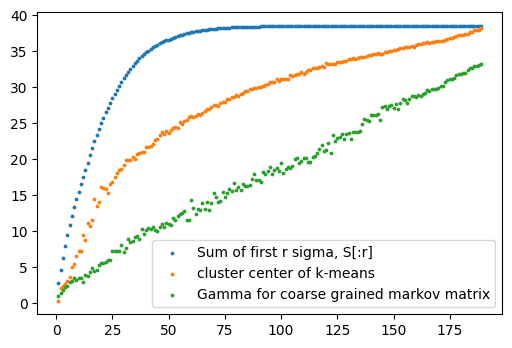

In [16]:
plt.figure(dpi=100)
plt.scatter(np.arange(1,len(original_S)),S_theory,s=3,label='Sum of first r sigma, S[:r]')
# plt.scatter(np.arange(1,len(original_S)),[np.sum(i) for i in pca_pxy_norm],s=3,label='sum(S) for pca_norm')
plt.scatter(np.arange(1,len(original_S)),[np.sum(i) for i in center_cluster_norm_S],s=3,label='cluster center of k-means')
plt.scatter(np.arange(1,len(original_S)),S_list,s=3,label='Gamma for coarse grained markov matrix')
plt.legend()

plt.show()

### coarse-graining twice

\Gamma 38.51641545109923
\gamma 0.202717976058417
EI 1.9821602521656874
122
(190, 122)


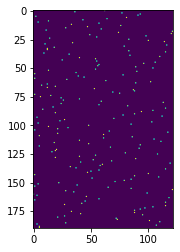

(122, 122)
\Gamma 27.584600730762364
\gamma 0.22610328467838003
EI 1.7212054632330183
64


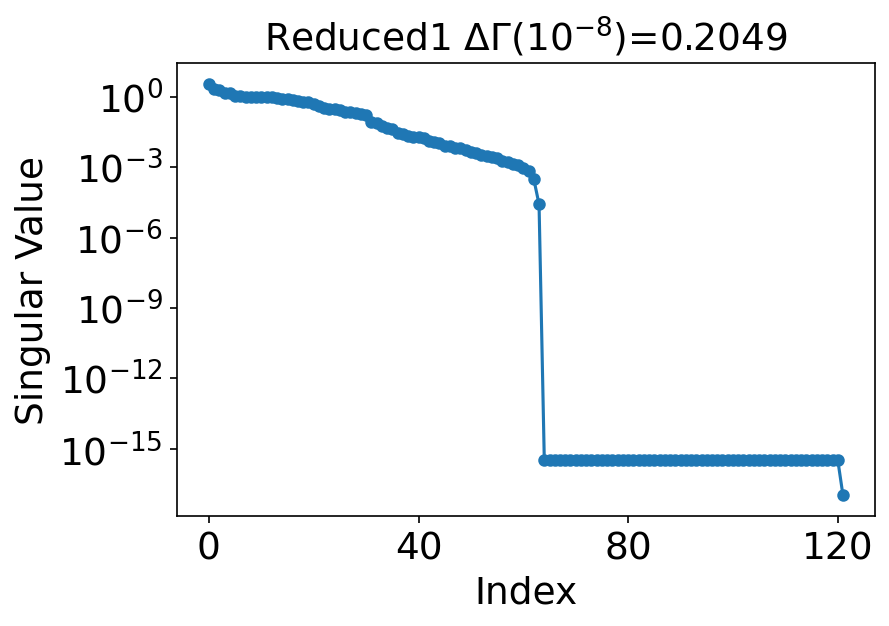

In [32]:
'k-means'
from sklearn.cluster import KMeans

# Perform SVD
U, original_S, V = np.linalg.svd(original_markov, full_matrices=False)
print(r'\Gamma',np.sum(original_S))
print(r'\gamma',np.sum(original_S)/len(original_S))
print('EI',calc_ei(original_markov)[4])
vec = V.T

epsilon = 1e-14
r = original_S[original_S>epsilon].shape[0]
n=original_markov.shape[0]
pca_pxy = original_markov @ vec[:,:r]
kmeans = KMeans(n_clusters=r,random_state=1)

print(r)
kmeans.fit(pca_pxy)
labels = [(i,kmeans.labels_[i]) for i in range(len(kmeans.labels_))]
cluster_centers = kmeans.cluster_centers_
phi = np.zeros([n,r])
for i in range(len(labels)):
    phi[labels[i][0],labels[i][1]] = 1
print(phi.shape)
plt.imshow(phi)
plt.show()
        

reduced_flow = phi.T @ original_flow @ phi

# Normalize the reduced flow matrix to create a reduced Markov matrix
reduced_markov = reduced_flow.copy()
for i in range(reduced_flow.shape[0]):
    normalize = np.sum(reduced_flow[i, :])
    if normalize > 0:
        reduced_markov[i, :] = reduced_flow[i, :] / normalize
    else:
        reduced_markov[i, i] = 1

        
# Perform SVD
print(reduced_markov.shape)
U, reduced_S, V = np.linalg.svd(reduced_markov, full_matrices=False)

# Plot the singular values
plt.figure(dpi=150)
plt.plot(range(len(reduced_S)),reduced_S,marker='.',markersize=10)
print(r'\Gamma',np.sum(reduced_S))
print(r'\gamma',np.sum(reduced_S)/len(reduced_S))
print('EI',calc_ei(reduced_markov)[4])

r = reduced_S[reduced_S>(1e-8)].shape[0]
print(r)
n = len(reduced_S)
d_gamma = np.sum(reduced_S[:r])/r - np.sum(reduced_S)/n


set_plot_info('Index','Singular Value',fontsize=18)
plt.title('Reduced1 ' + r'$\Delta \Gamma(10^{-8})$='+f'{d_gamma:.4f}',fontsize=18)
plt.xticks([0,40,80,120])
plt.yscale('log')
plt.show()


64
(64, 64)
\Gamma 13.76358706571953
\gamma 0.21505604790186766
0.10223976047793709


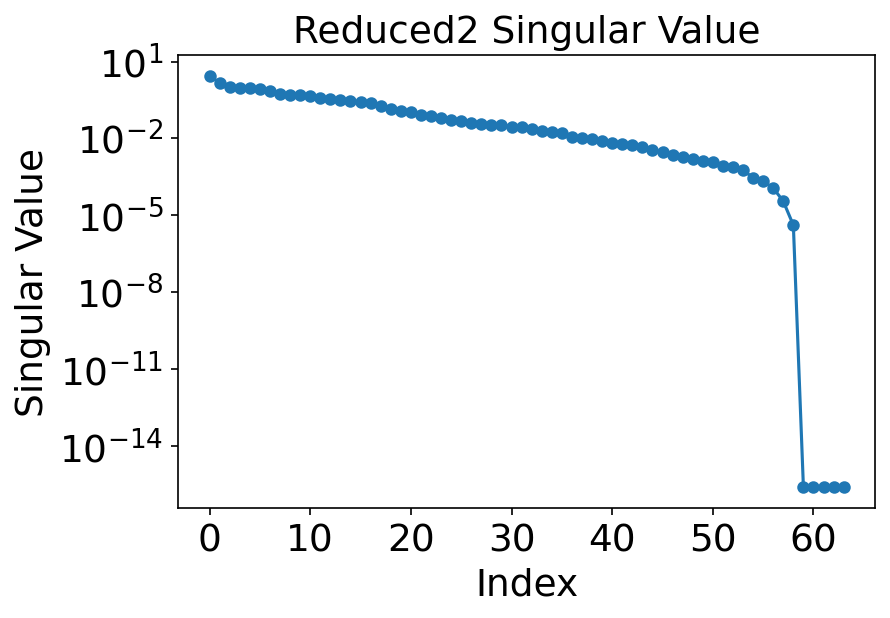

In [33]:
U, reduced_S, V = np.linalg.svd(reduced_markov, full_matrices=False)
vec = V.T
epsilon = 1e-8
r = len(reduced_S[reduced_S>epsilon])
print(r)
n=reduced_markov.shape[0]
pca_pxy = reduced_flow @ vec[:,:r]

kmeans = KMeans(n_clusters=r,random_state=1)
kmeans.fit(pca_pxy)
labels = [(i,kmeans.labels_[i]) for i in range(len(kmeans.labels_))]
cluster_centers = kmeans.cluster_centers_
phi2 = np.zeros([n,r])
for i in range(len(labels)):
    phi2[labels[i][0],labels[i][1]] = 1

reduced_flow2 = phi2.T @ reduced_flow @ phi2

# Normalize the reduced flow matrix to create a reduced Markov matrix
reduced_markov2 = reduced_flow2.copy()
for i in range(reduced_flow2.shape[0]):
    normalize = np.sum(reduced_flow2[i, :])
    if normalize > 0:
        reduced_markov2[i, :] = reduced_flow2[i, :] / normalize
    else:
        reduced_markov2[i, :] = np.zeros(reduced_markov2.shape[1])
        
print(reduced_markov2.shape)
U, reduced_S, V = np.linalg.svd(reduced_markov2, full_matrices=False)
# Plot the singular values
plt.figure(dpi=150)
plt.plot(range(len(reduced_S)),reduced_S,marker='.',markersize=10)
print(r'\Gamma',np.sum(reduced_S))
print(r'\gamma',np.sum(reduced_S)/len(reduced_S))
# r = 120

d_gamma = np.sum(reduced_S[:r])/r - np.sum(reduced_S)/n
print(d_gamma)
set_plot_info('Index','Singular Value',fontsize=18)
plt.title('Reduced2 Singular Value',fontsize=18)
plt.yscale('log')
plt.show()

(190, 122) (122, 64)
(190, 64)


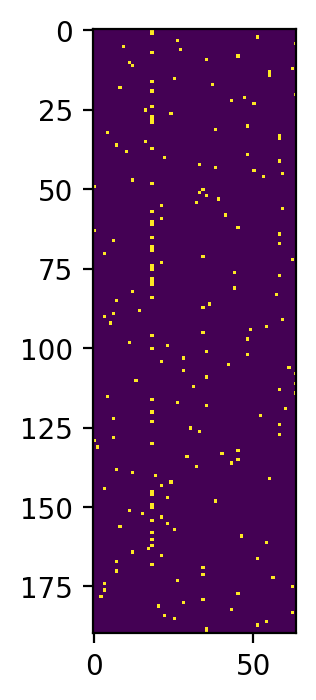

((64,),
 array([ 3.,  1.,  1.,  5.,  2.,  1.,  4.,  5.,  2.,  1.,  1.,  3.,  5.,
         1.,  1.,  1.,  2.,  1., 38.,  1.,  1.,  7.,  2.,  3.,  2.,  3.,
         3.,  1.,  3.,  1.,  1.,  1.,  2.,  3.,  7.,  7.,  1.,  1.,  3.,
         1.,  1.,  1.,  1.,  3.,  2.,  5.,  1.,  1.,  4.,  1.,  2.,  3.,
         1.,  1.,  3.,  3.,  1.,  1.,  9.,  3.,  1.,  1.,  4.,  5.]))

In [25]:
print(phi.shape,phi2.shape)
com_phi = phi@phi2
print(com_phi.shape)


plt.figure(dpi=200)
plt.imshow(com_phi)
plt.show()
group_list = np.argmax(com_phi,axis=1)
np.sum(com_phi,axis=0).shape,np.sum(com_phi,axis=0)

[178] [ 70  90 144 174 176]
{70: 'Germany', 90: 'Italy', 144: 'Russian', 174: 'Turkey', 176: 'UK', 178: 'USA'}


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


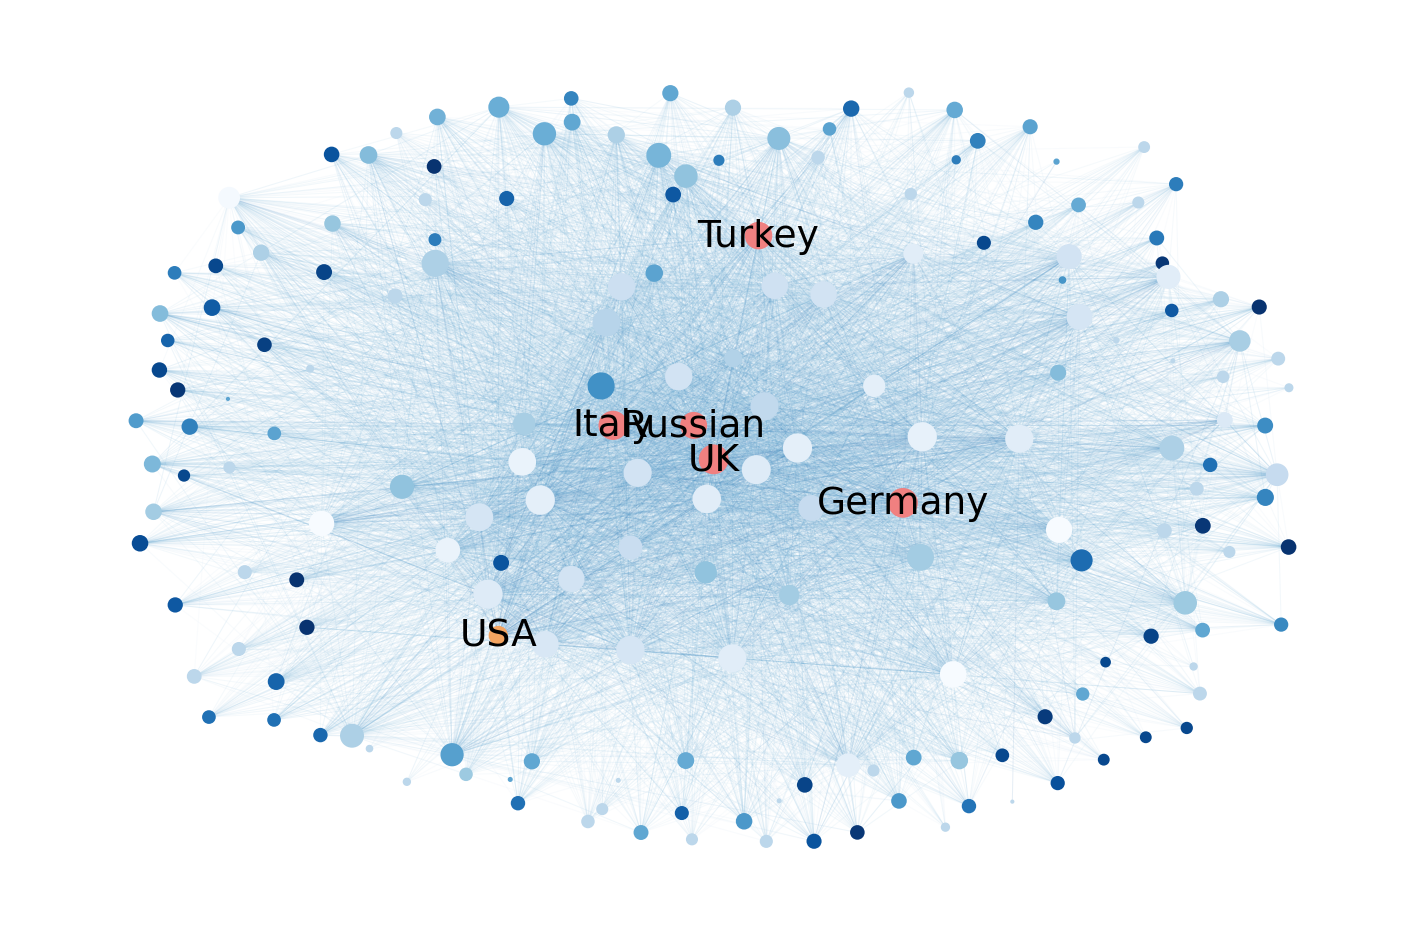

In [26]:

'visualizing graph'

G = nx.Graph()
n=flow_matrix.shape[0]
#node
for i in range(n):
    G.add_node(i)

'edge'
for i in range(n):
    for j in range(i+1, n):  # 避免重复添加边
        if flow_matrix[i, j] != 0:  # 如果i和j之间有边
            G.add_edge(i, j, weight=np.log(flow_matrix[i, j]))


degrees = [G.degree(n) for n in G.nodes()]
pos = nx.spring_layout(G,k=3, iterations=20,seed=0)  # 节点的布局
plt.figure(figsize=(12, 8),dpi=150)  # 设置画布大小
n = len(group_list)

country_index1 = np.where(com_phi[:,2])[0]#取第i个分组的国家
country_index2 = np.where(com_phi[:,3])[0]#取第i个分组的国家

print(country_index1,country_index2)
colors = []
labels = {}
for i in range(n):
    if i in country_index1:
        colors.append('sandybrown')
        labels[i] = country_id_group[i,0].split('_')[0]
    elif i in country_index2: 
        colors.append('lightcoral')
        labels[i] = country_id_group[i,0].split('_')[0]
    else:
        colors.append(plt.cm.Blues(group_list[i]/len(set(group_list))) )
print(labels)
nx.draw_networkx_nodes(G, pos, node_size=degrees,node_color=colors,cmap=plt.cm.Blues)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=18)

weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
weights_normalized = (weights - weights.min()) / (weights.max() - weights.min())
cmap = plt.cm.Blues  # 你可以选择matplotlib中的任何预设颜色映射
# 绘制边，根据权重调整颜色
edges = nx.draw_networkx_edges(G, pos, edge_color=weights_normalized, alpha=0.1,edge_cmap=cmap,width=0.5)
plt.axis("off")
# 显示图形
plt.show()


In [27]:
len(G.edges)

5897

64


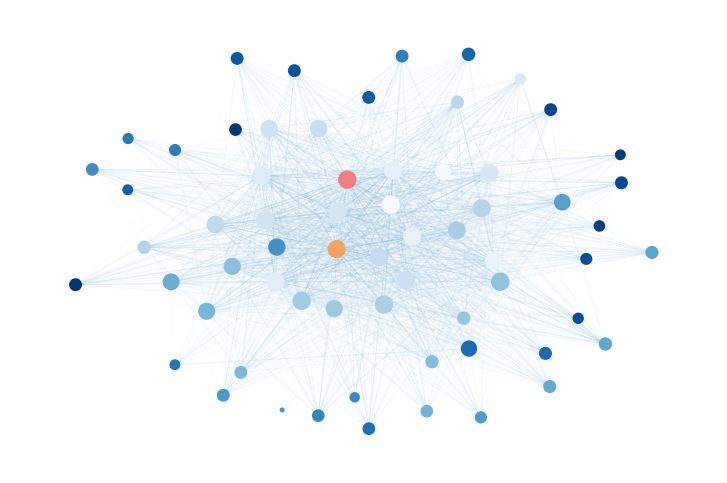

In [28]:


# 示例：创建一个4*4的邻接矩阵
# 创建一个空的无向图
G = nx.Graph()
n=reduced_flow2.shape[0]
print(n)
# 添加节点
for i in range(n):
#     if i != 0 and i != 1:
    G.add_node(i)

# 根据邻接矩阵添加带权重的边
for i in range(n):
    for j in range(i+1, n):  # 避免重复添加边
        if reduced_flow2[i, j] != 0:  # 如果i和j之间有边
            G.add_edge(i, j, weight=np.log(reduced_flow2[i, j]))

plt.figure(dpi=150)
degrees = [G.degree(n) for n in G.nodes()]
colors = []
for i in range(n):
    if i == 2:
        colors.append('sandybrown')
    elif i == 3:
        colors.append('lightcoral')
    else:
        colors.append(plt.cm.Blues(i/n))
# pos = nx.circular_layout(G)  # 节点的布局
pos = nx.spring_layout(G,k=3, iterations=20,seed=0)  # 节点的布局
# nx.draw(G, pos, with_labels=True,node_color='lightblue', font_size=10)  # 绘制节点和边
nx.draw_networkx_nodes(G, pos, node_size=degrees,node_color=colors)
# edge_labels = nx.get_edge_attributes(G, 'weight')  # 获取边的权重
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)  # 显示边的权重
# 根据边的权重调整边的粗细
weights = [G[u][v]['weight'] for u, v in G.edges()]
# 将权重映射到宽度值，例如，通过将权重标准化到1到5的范围
weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
# 标准化权重以用于颜色映射
weights_normalized = (weights - weights.min()) / (weights.max() - weights.min())
# 选择一个颜色映射
cmap = plt.cm.Blues  # 你可以选择matplotlib中的任何预设颜色映射
# 绘制边，根据权重调整颜色
edges = nx.draw_networkx_edges(G, pos, edge_color=weights_normalized, alpha=0.1,edge_cmap=cmap, width=0.5)
# 显示图形
plt.axis("off")
plt.show()


In [29]:
len(G.edges)

1253